In [1]:
# from zeno_client import ZenoClient, ZenoMetric
import pandas as pd
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/jhsia2/ragged')
from file_utils import load_json



In [2]:
root_dir = os.getenv('DBQA')
results_dir = os.path.join(root_dir, 'reader_results')

# 1a. Create and save dataframe compilation

In [9]:
def get_precision(guess_wiki_id_set, gold_wiki_id_set):
    precision = np.mean([[s in gold_wiki_id_set] for s in guess_wiki_id_set])
    return precision
def get_recall(guess_wiki_id_set, gold_wiki_id_set):
    # print(guess_wiki_id_set)
    # print(gold_wiki_id_set)
    recall = np.mean([[s in guess_wiki_id_set] for s in gold_wiki_id_set]) if len(gold_wiki_id_set) > 0 else 0.0
    return recall

def combine_gold_and_compiled(output_data, gold_data, questions_categorized, is_bioasq = False):
    if is_bioasq:
        docid_key = 'pmid'
        docid_name = 'pm'
        section_key = 'section'
        section_name = 'sec'
    else:
        docid_key = 'wikipedia_id'
        docid_name = 'wiki'
        section_key = 'start_paragraph_id'
        section_name = 'par'
    
    for i, (od, gd) in enumerate(zip(output_data, gold_data)):
        if(od['id'] != gd['id']):
            print(od, gd)
            break
        # od['dataset'] = gd['dataset']
        od['question_category'] = questions_categorized[od['id']]
        od['gold_answer_set'] = gd['output']['answer_set']
        od[f'gold_{docid_name}_id_set'] = gd['output'][f'{docid_name}_id_set']
        od[f'gold_{docid_name}_{section_name}_id_set'] = gd['output'][f'{docid_name}_{section_name}_id_set']
        od['gold_title_set'] = gd['output']['title_set']
    return output_data
def get_reader_df(top_k, combined_data, is_bioasq = False):
    if is_bioasq:
        docid_key = 'pmid'
        docid_name = 'pm'
        section_key = 'section'
        section_name = 'sec'
    else:
        docid_key = 'wikipedia_id'
        docid_name = 'wiki'
        section_key = 'start_paragraph_id'
        section_name = 'par'
    return pd.DataFrame(
        {
            "question": [d['input'] for d in combined_data],
            # "dataset": [d['dataset'] for d in combined_data],
            "question_category": [d['question_category'] for d in combined_data],
            "id": [d['id'] for d in combined_data],
            "output": [
                # json.dumps(
                    {   
                        "gold answer set": ', '.join(d['gold_answer_set']),
                        # "gold title set": ', '.join(d['gold_title_set']),
                        # "gold context set": '\n'.join(d['gold_text_set']),
                        # "gold context": d['gold_context'],
                        "answer": d["output"]["answer"],
                        # "retrieved context": [
                        #     {
                        #         # "{docid_name}_id": None,
                        #         # "text": None,
                        #         # "score": None,
                        #         # "{docid_name}_id_match": None,
                        #         # "{docid_name}_{section_name}_id_match": None
                        #     }
                        # ] if top_k == 'baseline' else [
                        #     {
                        #         f"{docid_name}_id": "[{idx}]({url})".format(
                        #             idx=id2title.get(r[f"{docid_name}_id"], 'Title not available.'),
                        #             url="https://pubmed.ncbi.nlm.nih.gov/"
                        #             + r[f"{docid_name}_id"],
                        #         ),
                        #         "text": r["text"],
                        #         # "score": r.get('score', None),
                        #         f"{docid_name}_id_match": r[f"{docid_name}_id_match"],
                        #         f"{docid_name}_{section_name}_id_match": r[f"{docid_name}_{section_name}_id_match"],
                        #         "answer_in_context": r["answer_in_context"]
                        #     }
                        #     if len(r['text'])!=0 else {}
                        # for r in d["output"]["retrieved"]
                        # ],
                    }
                # )
                for d in combined_data
            ],
            
            f"gold {docid_name}_{section_name}_id set size": [
                len(d[f"gold_{docid_name}_{section_name}_id_set"]) for d in combined_data
            ],
            # "max_score": [0 for d in combined_data] if top_k == 'baseline' else [
            #     d["output"]["retrieved"][0]["score"] for d in combined_data
            # ],
            # "avg_score": [0 for d in combined_data] if top_k == 'baseline' else [
            #     np.mean([r["score"] for r in d["output"]["retrieved"]]) for d in combined_data
            # ],
            "f1": [
                d["output"]["answer_evaluation"]["f1"] for d in combined_data
            ],
            # "bertscore_precision": [
            #     d["output"]["answer_evaluation"]["bertscore"]["bertscore_precision"] for d in combined_data
            # ],
            # "bertscore_recall": [
            #     d["output"]["answer_evaluation"]["bertscore"]["bertscore_recall"] for d in combined_data
            # ],
            # "bertscore_f1": [
            #     d["output"]["answer_evaluation"]["bertscore"]["bertscore_f1"] for d in combined_data
            # ],
            "exact_match": [
                d["output"]["answer_evaluation"]["exact_match"] for d in combined_data
            ],
            "substring_match": [
                d["output"]["answer_evaluation"]["substring_match"] for d in combined_data
            ],
            "answer_in_context": [
                d["output"]["summary context evaluation"]["answer_in_context"] for d in combined_data
            ],
            f"any {docid_name}_id_match": [False for d in combined_data] if top_k == 'baseline' else [
                d["output"]["summary context evaluation"][f"{docid_name}_id_match"] for d in combined_data
            ],
            f"any {docid_name}_{section_name}_id_match": [False for d in combined_data] if top_k == 'baseline' else [
                d["output"]["summary context evaluation"][f"{docid_name}_{section_name}_id_match"] for d in combined_data
            ],
            f"precision {docid_name}_id_match": [0 for d in combined_data] if top_k == 'baseline' else [
                get_precision(set([r.get(f"{docid_name}_id", None) for r in d["output"]["retrieved"]]), d[f'gold_{docid_name}_id_set']) for d in combined_data
            ],
            f"precision {docid_name}_{section_name}_id_match": [0 for d in combined_data] if top_k == 'baseline' else [
                get_precision(set([r.get(f"{docid_name}_{section_name}_id", None) for r in d["output"]["retrieved"]]), d[f'gold_{docid_name}_{section_name}_id_set']) for d in combined_data
            ],
            f"recall {docid_name}_id_match": [0 for d in combined_data] if top_k == 'baseline' else [
                get_recall(set([r.get(f"{docid_name}_id", None) for r in d["output"]["retrieved"]]), d[f'gold_{docid_name}_id_set']) for d in combined_data
            ],
            f"recall {docid_name}_{section_name}_id_match": [0 for d in combined_data] if top_k == 'baseline' else [
                get_recall(set([r.get(f"{docid_name}_{section_name}_id", None) for r in d["output"]["retrieved"]]), d[f'gold_{docid_name}_{section_name}_id_set']) for d in combined_data
            ],
        }
    )

In [22]:
output_by_dataset = {}
for dataset in ['nq', 'hotpotqa', 'complete_bioasq']:
# dataset = 'complete_bioasq'
    if 'bioasq' in dataset:
        docid_key = 'pmid'
        docid_name = 'pm'
        section_key = 'section'
        section_name = 'sec'
    else:
        docid_key = 'wikipedia_id'
        docid_name = 'wiki'
        section_key = 'start_paragraph_id'
        section_name = 'par'

    id2title = load_json(os.path.join(root_dir, f'data/corpus_files/{docid_name}_{section_name}_id2title.json'))

    gold_data = load_json(os.path.join(root_dir, 'data/gold_zeno_files', f"gold_{dataset.split('complete_')[-1]}_zeno_file.json"), sort_by_id = True)

    questions_categorized = load_json(os.path.join(root_dir, f'data/questions_categorized/{dataset}_questions_categorized.json'))

    output_by_dataset[dataset] = {}

    reader_models = ['flanUl2', 'llama_70b', 'flanT5', 'llama_7b', 'llama_70b_2000_truncation', 'llama_7b_2000_truncation']
    retriever_models = ['colbert','gold', 'bm25']
    top_ks= ["baseline", "top1", "top2", "top3", "top5", "top10", "top20", "top30", "top50"]
    print(retriever_models)
    print(reader_models)
    print(top_ks)
    output_dfs = {}
    for retriever_model in retriever_models:
        for reader_model in reader_models:
            if output_dfs.get(reader_model, None) == None:
                output_dfs[reader_model] = {}
                
        
            print('retriever', retriever_model)
            print('reader', reader_model)
            if retriever_model == 'gold':

                data = load_json(os.path.join(results_dir, reader_model, 'bioasq' if 'bioasq' in dataset else dataset, 'gold', "reader_results_zeno.json"))
                        
                combined_data = combine_gold_and_compiled(data, gold_data, questions_categorized,'bioasq' in dataset)
                output_df = get_reader_df('gold', combined_data, 'bioasq' in dataset)
                output_dfs[reader_model]['gold'] = output_df
            else:
                for top_k in top_ks:
                    print(top_k)
                    data = load_json(os.path.join(results_dir, reader_model, dataset, retriever_model, f"{top_k}/reader_results_zeno.json"))
                            
                    combined_data = combine_gold_and_compiled(data, gold_data, questions_categorized,'bioasq' in dataset)
                    output_df = get_reader_df(top_k, combined_data, 'bioasq' in dataset)
                    if output_dfs[reader_model].get(retriever_model, None) == None:
                        output_dfs[reader_model][retriever_model] = {}
                    if top_k == 'baseline':
                        output_dfs[reader_model]['no_context'] = output_df
                    else:
                        output_dfs[reader_model][retriever_model][top_k] = output_df
        output_by_dataset[dataset]= output_dfs
import pickle
with open(os.path.join(root_dir, 'combined_zeno.pkl'), 'wb') as outp:
    pickle.dump(output_by_dataset, outp)

loading from /data/tir/projects/tir6/general/afreens/dbqa/data/corpus_files/pm_sec_id2title.json


loading from /data/tir/projects/tir6/general/afreens/dbqa/data/gold_zeno_files/gold_bioasq_zeno_file.json
loading from /data/tir/projects/tir6/general/afreens/dbqa/data/questions_categorized/complete_bioasq_questions_categorized.json


# 1b. Load compiled dataframes

In [10]:
import pickle
import os
reader_models = ['flanUl2', 'llama_70b', 'flanT5', 'llama_7b', 'llama_70b_2000_truncation', 'llama_7b_2000_truncation']
# reader_models = ['llama_7b_2000_truncation']
# retriever_models = ['gold','colbert', 'bm25']
retriever_models = ['colbert','gold', 'bm25']
# retriever_models = ['bm25']
top_ks= ["baseline", "top1", "top2", "top3", "top5", "top10", "top20", "top30", "top50"]

with open(os.path.join(os.getenv('DBQA'), 'combined_zeno.pkl'), 'rb') as f:
    output_by_dataset = pickle.load(f)

In [8]:
from matplotlib.cm import get_cmap

name = "tab10"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list

/tmp/ipykernel_752598/1510399323.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap


# 2a. Plot all instances (bm25 v. colbert) by dataset

flanT5 colbert
flanT5 bm25
flanUl2 colbert
flanUl2 bm25
llama_70b colbert
llama_70b bm25
llama_7b colbert
llama_7b bm25


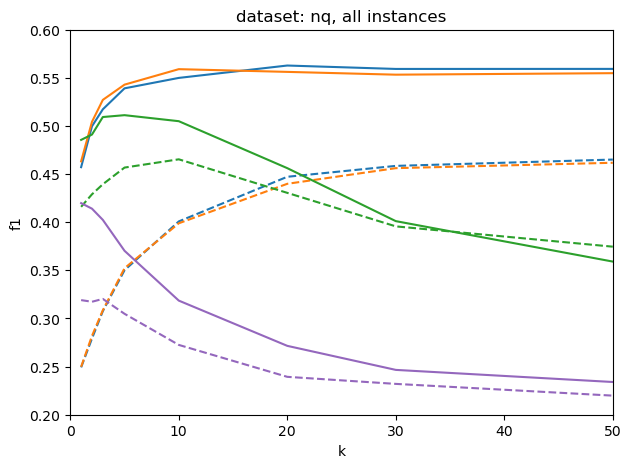

In [95]:
linestyles = ['-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'p']
reader_models.sort()
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]
plt.figure(figsize=(7, 5))
reader_models.sort()
dataset = 'nq'
reader_metric = 'f1'

output_dfs = output_by_dataset[dataset]


for r, reader_model in enumerate(reader_models):
    if 'truncation' in reader_model:
        continue
    for r2, retriever_model in enumerate(['colbert', 'bm25']):
        reader_perf_by_k = []
        for i, top_k in enumerate(top_ks[1:]):
            k_df =output_dfs[reader_model][retriever_model][top_k]
            answer_in_context_df = k_df # CAN CHANGE SLICE CONDITION HERE
            reader_perf_by_k.append(np.mean(answer_in_context_df[reader_metric].values)) # CAN CHANGE READER METRIC HERE
        plt.plot([1, 2, 3, 5, 10 , 20 , 30 , 50], reader_perf_by_k, label = f'{reader_model} x {retriever_model}', color = colors[r%len(reader_models)], linestyle = linestyles[r2])

plt.title(f'dataset: {dataset}, all instances')

plt.xlabel('k')
plt.ylabel(reader_metric)
plt.ylim(top = 0.6, bottom = 0.2)
plt.xlim(left = 0, right = 50)
# plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
# plt.savefig(os.path.join('/data/tir/projects/tir6/general/afreens/dbqa/figs', f'{dataset}_all_instances.pdf') , bbox_inches='tight', pad_inches=0)
plt.show()

flanT5 colbert
flanT5 bm25
flanUl2 colbert
flanUl2 bm25
llama_70b colbert
llama_70b bm25
llama_7b colbert
llama_7b bm25


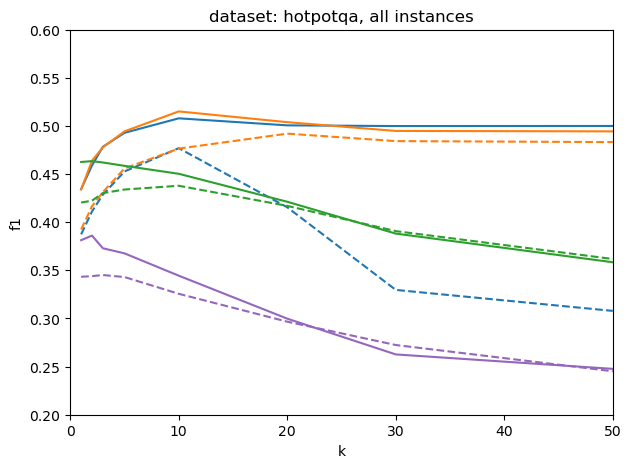

In [94]:
linestyles = ['-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'p']
reader_models.sort()
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]
plt.figure(figsize=(7, 5))
reader_models.sort()
dataset = 'hotpotqa'
reader_metric = 'f1'

output_dfs = output_by_dataset[dataset]


for r, reader_model in enumerate(reader_models):
    if 'truncation' in reader_model:
        continue
    for r2, retriever_model in enumerate(['colbert', 'bm25']):
        reader_perf_by_k = []
        for i, top_k in enumerate(top_ks[1:]):
            k_df =output_dfs[reader_model][retriever_model][top_k]
            answer_in_context_df = k_df# CAN CHANGE SLICE CONDITION HERE
            reader_perf_by_k.append(np.mean(answer_in_context_df[reader_metric].values)) # CAN CHANGE READER METRIC HERE
        plt.plot([1, 2, 3, 5, 10 , 20 , 30 , 50], reader_perf_by_k, label = f'{reader_model} x {retriever_model}', color = colors[r%len(reader_models)], linestyle = linestyles[r2])

plt.title(f'dataset: {dataset}, all instances')

plt.xlabel('k')
plt.ylabel(reader_metric)
plt.ylim(top = 0.6, bottom = 0.2)
plt.xlim(left = 0, right = 50)
# plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
# plt.savefig(os.path.join('/data/tir/projects/tir6/general/afreens/dbqa/figs', f'{dataset}_all_instances.pdf') , bbox_inches='tight', pad_inches=0)
plt.show()

flanT5 colbert
flanT5 bm25
flanUl2 colbert
flanUl2 bm25
llama_70b colbert
llama_70b bm25
llama_7b colbert
llama_7b bm25


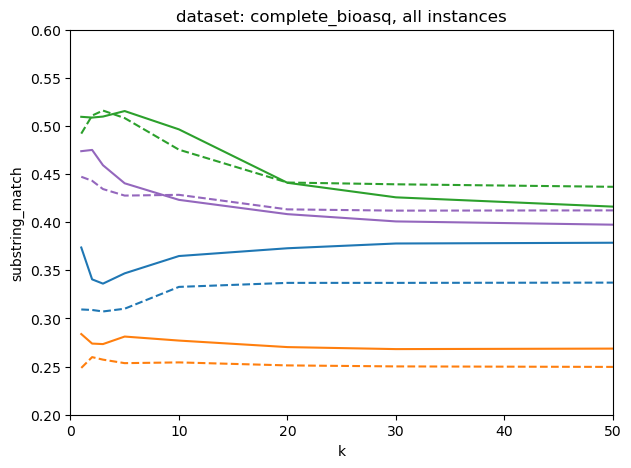

In [11]:
linestyles = ['-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'p']
reader_models.sort()
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]
plt.figure(figsize=(7, 5))
reader_models.sort()
dataset = 'complete_bioasq'
reader_metric = 'substring_match'

output_dfs = output_by_dataset[dataset]


for r, reader_model in enumerate(reader_models):
    if 'truncation' in reader_model:
        continue
    for r2, retriever_model in enumerate(['colbert', 'bm25']):
        reader_perf_by_k = []
        for i, top_k in enumerate(top_ks[1:]):
            k_df =output_dfs[reader_model][retriever_model][top_k]
            answer_in_context_df = k_df# CAN CHANGE SLICE CONDITION HERE
            reader_perf_by_k.append(np.mean(answer_in_context_df[reader_metric].values)) # CAN CHANGE READER METRIC HERE
        plt.plot([1, 2, 3, 5, 10 , 20 , 30 , 50], reader_perf_by_k, label = f'{reader_model} x {retriever_model}', color = colors[r%len(reader_models)], linestyle = linestyles[r2])

plt.title(f'dataset: {dataset}, all instances')

plt.xlabel('k')
plt.ylabel(reader_metric)
plt.ylim(top = 0.6, bottom = 0.2)
plt.xlim(left = 0, right = 50)
# plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
# plt.savefig(os.path.join('/data/tir/projects/tir6/general/afreens/dbqa/figs', f'{dataset}_all_instances.pdf') , bbox_inches='tight', pad_inches=0)
plt.show()

# 2b Plot by slice - Question Category

flanT5 colbert
flanT5 bm25
flanUl2 colbert
flanUl2 bm25
llama_70b colbert
llama_70b bm25
llama_7b colbert
llama_7b bm25


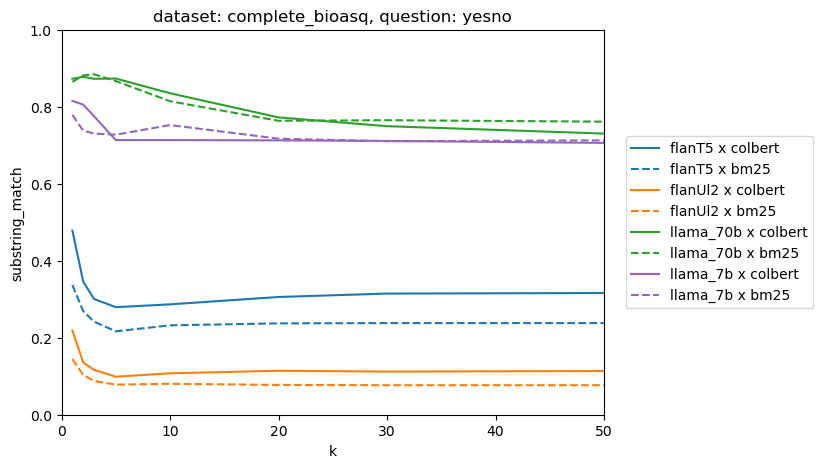

In [18]:
linestyles = ['-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'p']
reader_models.sort()
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]
plt.figure(figsize=(7, 5))
reader_models.sort()
dataset = 'complete_bioasq'
reader_metric = 'f1'

output_dfs = output_by_dataset[dataset]


for r, reader_model in enumerate(reader_models):
    if 'truncation' in reader_model:
        continue
    for r2, retriever_model in enumerate(['colbert', 'bm25']):
        reader_perf_by_k = []
        for i, top_k in enumerate(top_ks[1:]):
            k_df =output_dfs[reader_model][retriever_model][top_k]
            answer_in_context_df = k_df# CAN CHANGE SLICE CONDITION HERE
            reader_perf_by_k.append(np.mean(answer_in_context_df[reader_metric].values)) # CAN CHANGE READER METRIC HERE
        plt.plot([1, 2, 3, 5, 10 , 20 , 30 , 50], reader_perf_by_k, label = f'{reader_model} x {retriever_model}', color = colors[r%len(reader_models)], linestyle = linestyles[r2])

plt.title(f'dataset: {dataset}, all instances')

plt.xlabel('k')
plt.ylabel(reader_metric)
plt.ylim(top = 0.6, bottom = 0.2)
plt.xlim(left = 0, right = 50)
# plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
# plt.savefig(os.path.join('/data/tir/projects/tir6/general/afreens/dbqa/figs', f'{dataset}_all_instances.pdf') , bbox_inches='tight', pad_inches=0)
plt.show()

flanT5 colbert
flanT5 bm25
flanUl2 colbert
flanUl2 bm25
llama_70b colbert
llama_70b bm25
llama_7b colbert
llama_7b bm25


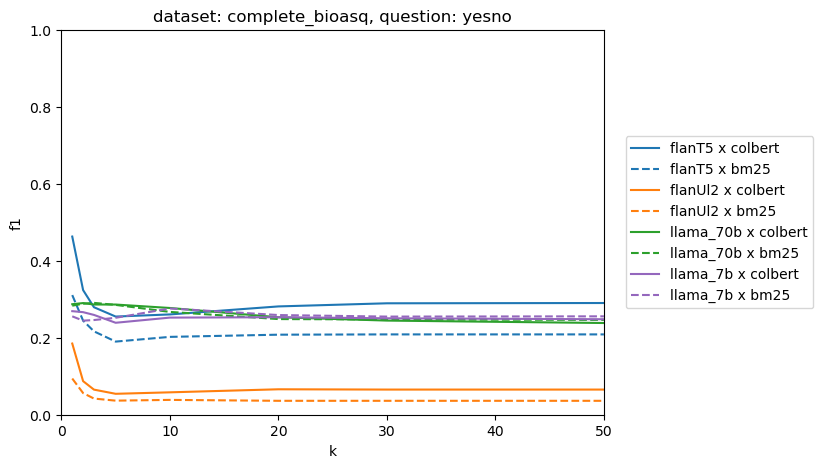

In [19]:
linestyles = ['-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'p']
# retriever = 'colbert'
reader_models.sort()
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]
plt.figure(figsize=(7, 5))
reader_models.sort()
dataset = 'complete_bioasq'
output_dfs = output_by_dataset[dataset]

reader_metric = 'f1'
question_category = 'yesno'
for r, reader_model in enumerate(reader_models):
    if 'truncation' in reader_model:
        continue
    for r2, retriever_model in enumerate(['colbert', 'bm25']):
        print(reader_model, retriever_model)
        reader_perf_by_k = []
        for i, top_k in enumerate(top_ks[1:]):
            k_df =output_dfs[reader_model][retriever_model][top_k]
            k_df = k_df.loc[k_df['question_category'] == question_category]
            answer_in_context_df = k_df# CAN CHANGE SLICE CONDITION HERE
            reader_perf_by_k.append(np.mean(answer_in_context_df[reader_metric].values)) # CAN CHANGE READER METRIC HERE
        plt.plot([1, 2, 3, 5, 10 , 20 , 30 , 50], reader_perf_by_k, label = f'{reader_model} x {retriever_model}', color = colors[r%len(reader_models)], linestyle = linestyles[r2])

plt.title(f'dataset: {dataset}, question: {question_category}')

plt.xlabel('k')
plt.ylabel(reader_metric)
plt.ylim(top = 1.0, bottom = 0.0)
plt.xlim(left = 0, right = 50)
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
# plt.savefig(os.path.join('/data/tir/projects/tir6/general/afreens/dbqa/figs', f'{dataset}_substring_all_instances.pdf') , bbox_inches='tight', pad_inches=0)
plt.show()

# 2b Plot by slice - Retriever Performance (without truncation)

/data/tir/projects/tir6/general/afreens/dbqa/figs/nq_colbert_no_match.pdf


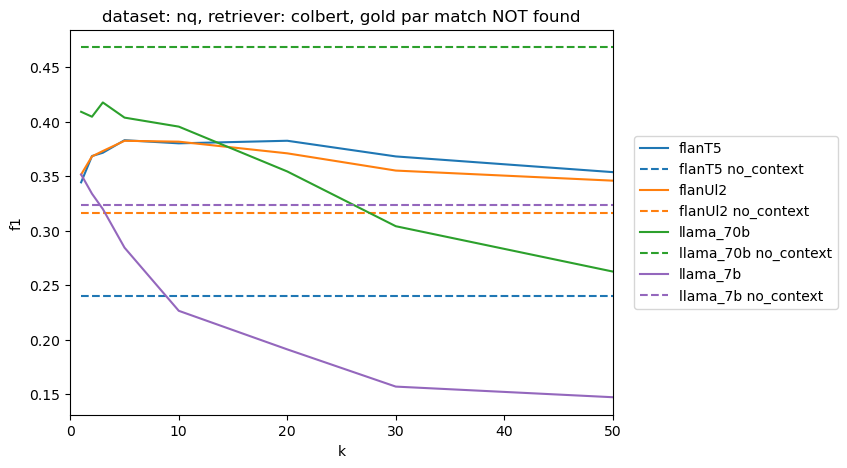

In [129]:
linestyles = ['-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'p']
retriever = 'colbert'
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]
plt.figure(figsize=(7, 5))
reader_models.sort()
dataset = 'nq'
reader_metric = 'f1'
if 'bioasq' in dataset:
    docid_key = 'pmid'
    docid_name = 'pm'
    section_key = 'section'
    section_name = 'sec'
else:
    docid_key = 'wikipedia_id'
    docid_name = 'wiki'
    section_key = 'start_paragraph_id'
    section_name = 'par'
output_dfs = output_by_dataset[dataset]
for r, reader_model in enumerate(reader_models):
    if 'truncation' in reader_model:
        continue
    reader_perf_by_k = []
    for i, top_k in enumerate(top_ks[1:]):
        k_df =output_dfs[reader_model][retriever][top_k]
        answer_in_context_df = k_df.loc[k_df[f'any {docid_name}_{section_name}_id_match'] == False]# CAN CHANGE SLICE CONDITION HERE
        reader_perf_by_k.append(np.mean(answer_in_context_df[reader_metric].values)) # CAN CHANGE READER METRIC HERE
    plt.plot([1, 2, 3, 5, 10 , 20 , 30 , 50], reader_perf_by_k, label = reader_model, color = colors[r%len(reader_models)], linestyle = linestyles[0])
    for i, baseline in enumerate(['no_context']):
        if 'truncation' in reader_model:
            continue 
        k_df =output_dfs[reader_model][baseline]
        answer_in_context_df = k_df # CAN CHANGE SLICE CONDITION HERE
        reader_perf = np.mean(answer_in_context_df['f1'].values) # CAN CHANGE READER METRIC HERE

        plt.hlines(y = reader_perf, xmin = 1, xmax = 50, label = f'{reader_model} {baseline}', color = colors[r%len(reader_models)], linestyle = linestyles[i+1])

plt.title(f'dataset: {dataset}, retriever: {retriever}, gold par match NOT found')

plt.xlabel('k')
plt.ylabel(reader_metric)
# plt.ylim(top = 0.6, bottom = 0.2)
plt.xlim(left = 0, right = 50)
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
filename = os.path.join('/data/tir/projects/tir6/general/afreens/dbqa/figs', f'{dataset}_{retriever}_no_match.pdf')
# plt.savefig(filename)
print(filename)
plt.show()

/home/jhsia2/miniforge-pypy3/envs/py10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jhsia2/miniforge-pypy3/envs/py10/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/data/tir/projects/tir6/general/afreens/dbqa/figs/hotpotqa_colbert_match.pdf


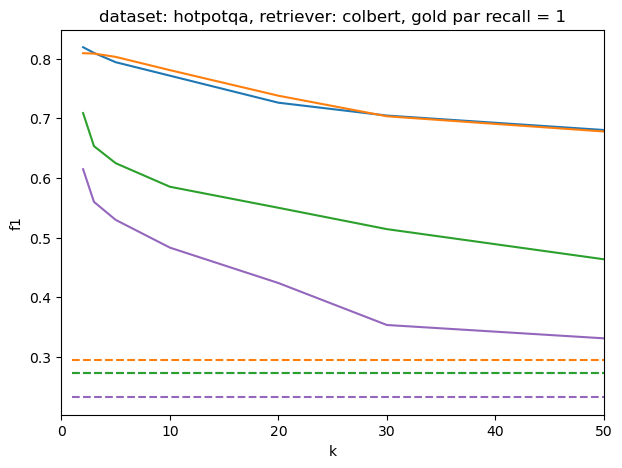

In [235]:
linestyles = ['-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'p']
retriever = 'colbert'
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]
plt.figure(figsize=(7, 5))
reader_models.sort()
dataset = 'hotpotqa'
reader_metric = 'f1'
if 'bioasq' in dataset:
    docid_key = 'pmid'
    docid_name = 'pm'
    section_key = 'section'
    section_name = 'sec'
else:
    docid_key = 'wikipedia_id'
    docid_name = 'wiki'
    section_key = 'start_paragraph_id'
    section_name = 'par'
output_dfs = output_by_dataset[dataset]
for r, reader_model in enumerate(reader_models):
    if 'truncation' in reader_model:
        continue
    reader_perf_by_k = []
    for i, top_k in enumerate(top_ks[1:]):
        k_df =output_dfs[reader_model][retriever][top_k]
        answer_in_context_df = k_df.loc[k_df[f'recall {docid_name}_{section_name}_id_match'] == 1.0]# CAN CHANGE SLICE CONDITION HERE
        reader_perf_by_k.append(np.mean(answer_in_context_df[reader_metric].values)) # CAN CHANGE READER METRIC HERE
    plt.plot([1, 2, 3, 5, 10 , 20 , 30 , 50], reader_perf_by_k, label = reader_model, color = colors[r%len(reader_models)], linestyle = linestyles[0])
    for i, baseline in enumerate(['no_context']):
        if 'truncation' in reader_model:
            continue 
        k_df =output_dfs[reader_model][baseline]
        answer_in_context_df = k_df # CAN CHANGE SLICE CONDITION HERE
        reader_perf = np.mean(answer_in_context_df['f1'].values) # CAN CHANGE READER METRIC HERE

        plt.hlines(y = reader_perf, xmin = 1, xmax = 50, label = f'{reader_model} {baseline}', color = colors[r%len(reader_models)], linestyle = linestyles[i+1])

plt.title(f'dataset: {dataset}, retriever: {retriever}, gold par recall = 1')

plt.xlabel('k')
plt.ylabel(reader_metric)
plt.xlim(left = 0, right = 50)
filename = os.path.join('/data/tir/projects/tir6/general/afreens/dbqa/figs', f'{dataset}_{retriever}_match.pdf')
# plt.savefig(filename, bbox_inches='tight', pad_inches=0)
print(filename)
plt.show()

# 2b Plot by slice - Retriever Performance (with 2k truncation)

/data/tir/projects/tir6/general/afreens/dbqa/figs/hotpotqa_colbert_match.pdf


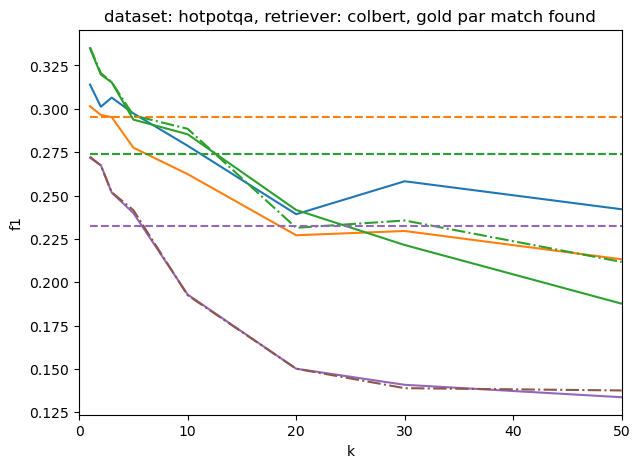

In [234]:
linestyles = ['-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'p']
retriever = 'colbert'
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]
plt.figure(figsize=(7, 5))
reader_models.sort()
dataset = 'hotpotqa'
if 'bioasq' in dataset:
    docid_key = 'pmid'
    docid_name = 'pm'
    section_key = 'section'
    section_name = 'sec'
else:
    docid_key = 'wikipedia_id'
    docid_name = 'wiki'
    section_key = 'start_paragraph_id'
    section_name = 'par'
output_dfs = output_by_dataset[dataset]
for r, reader_model in enumerate(reader_models):
    # if 'truncation' in reader_model:
    #     continue
    reader_perf_by_k = []
    for i, top_k in enumerate(top_ks[1:]):
        k_df =output_dfs[reader_model][retriever][top_k]
        answer_in_context_df = k_df.loc[k_df[f'recall {docid_name}_{section_name}_id_match'] == 0.0]# CAN CHANGE SLICE CONDITION HERE
        reader_perf_by_k.append(np.mean(answer_in_context_df['f1'].values)) # CAN CHANGE READER METRIC HERE
        if '7b' in reader_model:
            color = colors[3]
        if '70b' in reader_model:
            color = colors[2]
        else:
            color = colors[r%len(reader_models)]
        if 'truncation' in reader_model:
            linestyle = linestyles[2]
        else:
            linestyle = linestyles[0]
    plt.plot([1, 2, 3, 5, 10 , 20 , 30 , 50], reader_perf_by_k, label = reader_model, color = color, linestyle = linestyle)
    for i, baseline in enumerate(['no_context']):
        if 'truncation' in reader_model:
            continue 
        k_df =output_dfs[reader_model][baseline]
        answer_in_context_df = k_df # CAN CHANGE SLICE CONDITION HERE
        reader_perf = np.mean(answer_in_context_df['f1'].values) # CAN CHANGE READER METRIC HERE

        plt.hlines(y = reader_perf, xmin = 1, xmax = 50, label = f'{reader_model} {baseline}', color = colors[r%len(reader_models)], linestyle = linestyles[i+1])

plt.title(f'dataset: {dataset}, retriever: {retriever}, gold par match found')

plt.xlabel('k')
plt.ylabel('f1')
# plt.ylim(top = 0.6, bottom = 0.2)
plt.xlim(left = 0, right = 50)
filename = os.path.join('/data/tir/projects/tir6/general/afreens/dbqa/figs', f'{dataset}_{retriever}_no_match.pdf')
plt.savefig(filename,bbox_inches='tight', pad_inches=0)
print(filename)
plt.show()

/data/tir/projects/tir6/general/afreens/dbqa/figs/complete_bioasq_colbert_match.pdf


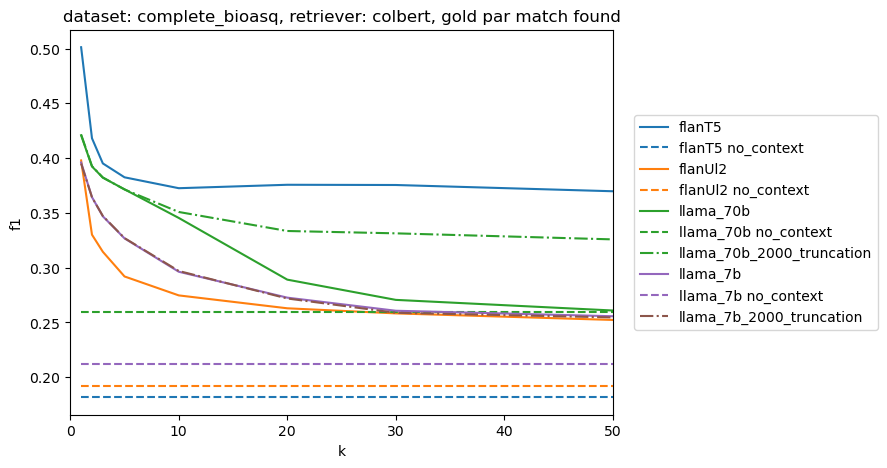

In [217]:
linestyles = ['-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'p']
retriever = 'colbert'
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]
plt.figure(figsize=(7, 5))
reader_models.sort()
dataset = 'complete_bioasq'
if 'bioasq' in dataset:
    docid_key = 'pmid'
    docid_name = 'pm'
    section_key = 'section'
    section_name = 'sec'
else:
    docid_key = 'wikipedia_id'
    docid_name = 'wiki'
    section_key = 'start_paragraph_id'
    section_name = 'par'
output_dfs = output_by_dataset[dataset]
for r, reader_model in enumerate(reader_models):
    # if 'truncation' in reader_model:
    #     continue
    reader_perf_by_k = []
    for i, top_k in enumerate(top_ks[1:]):
        k_df =output_dfs[reader_model][retriever][top_k]
        answer_in_context_df = k_df.loc[k_df[f'any {docid_name}_{section_name}_id_match'] == True]# CAN CHANGE SLICE CONDITION HERE
        reader_perf_by_k.append(np.mean(answer_in_context_df['f1'].values)) # CAN CHANGE READER METRIC HERE
        if '7b' in reader_model:
            color = colors[3]
        if '70b' in reader_model:
            color = colors[2]
        else:
            color = colors[r%len(reader_models)]
        if 'truncation' in reader_model:
            linestyle = linestyles[2]
        else:
            linestyle = linestyles[0]
    plt.plot([1, 2, 3, 5, 10 , 20 , 30 , 50], reader_perf_by_k, label = reader_model, color = color, linestyle = linestyle)
    for i, baseline in enumerate(['no_context']):
        if 'truncation' in reader_model:
            continue 
        k_df =output_dfs[reader_model][baseline]
        answer_in_context_df = k_df # CAN CHANGE SLICE CONDITION HERE
        reader_perf = np.mean(answer_in_context_df['f1'].values) # CAN CHANGE READER METRIC HERE

        plt.hlines(y = reader_perf, xmin = 1, xmax = 50, label = f'{reader_model} {baseline}', color = colors[r%len(reader_models)], linestyle = linestyles[i+1])

plt.title(f'dataset: {dataset}, retriever: {retriever}, gold par match found')

plt.xlabel('k')
plt.ylabel('f1')
# plt.ylim(top = 0.6, bottom = 0.2)
plt.xlim(left = 0, right = 50)
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
filename = os.path.join('/data/tir/projects/tir6/general/afreens/dbqa/figs', f'{dataset}_{retriever}_match.pdf')
# plt.savefig(filename)
print(filename)
plt.show()

/data/tir/projects/tir6/general/afreens/dbqa/figs/nq_colbert_match.pdf


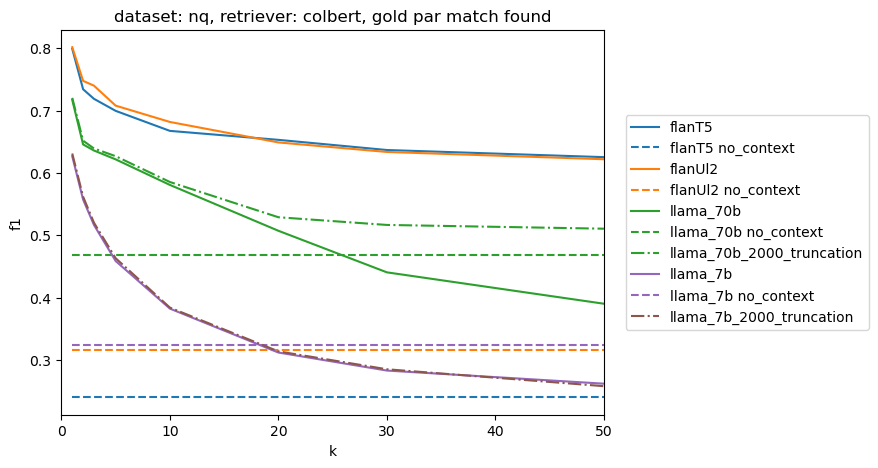

In [147]:
linestyles = ['-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'p']
retriever = 'colbert'
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]
plt.figure(figsize=(7, 5))
reader_models.sort()
dataset = 'nq'
if 'bioasq' in dataset:
    docid_key = 'pmid'
    docid_name = 'pm'
    section_key = 'section'
    section_name = 'sec'
else:
    docid_key = 'wikipedia_id'
    docid_name = 'wiki'
    section_key = 'start_paragraph_id'
    section_name = 'par'
output_dfs = output_by_dataset[dataset]
for r, reader_model in enumerate(reader_models):
    # if 'truncation' in reader_model:
    #     continue
    reader_perf_by_k = []
    for i, top_k in enumerate(top_ks[1:]):
        k_df =output_dfs[reader_model][retriever][top_k]
        answer_in_context_df = k_df.loc[k_df[f'any {docid_name}_{section_name}_id_match'] == True]# CAN CHANGE SLICE CONDITION HERE
        reader_perf_by_k.append(np.mean(answer_in_context_df['f1'].values)) # CAN CHANGE READER METRIC HERE
        if '7b' in reader_model:
            color = colors[3]
        if '70b' in reader_model:
            color = colors[2]
        else:
            color = colors[r%len(reader_models)]
        if 'truncation' in reader_model:
            linestyle = linestyles[2]
        else:
            linestyle = linestyles[0]
    plt.plot([1, 2, 3, 5, 10 , 20 , 30 , 50], reader_perf_by_k, label = reader_model, color = color, linestyle = linestyle)
    for i, baseline in enumerate(['no_context']):
        if 'truncation' in reader_model:
            continue 
        k_df =output_dfs[reader_model][baseline]
        answer_in_context_df = k_df # CAN CHANGE SLICE CONDITION HERE
        reader_perf = np.mean(answer_in_context_df['f1'].values) # CAN CHANGE READER METRIC HERE

        plt.hlines(y = reader_perf, xmin = 1, xmax = 50, label = f'{reader_model} {baseline}', color = colors[r%len(reader_models)], linestyle = linestyles[i+1])

plt.title(f'dataset: {dataset}, retriever: {retriever}, gold par match found')

plt.xlabel('k')
plt.ylabel('f1')
plt.xlim(left = 0, right = 50)
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
filename = os.path.join('/data/tir/projects/tir6/general/afreens/dbqa/figs', f'{dataset}_{retriever}_match.pdf')
# plt.savefig(filename)
print(filename)
plt.show()

In [ ]:
linestyles = ['-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'p']
retriever = 'colbert'
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]
plt.figure(figsize=(7, 5))
reader_models.sort()
dataset = 'complete_bioasq'
if 'bioasq' in dataset:
    docid_key = 'pmid'
    docid_name = 'pm'
    section_key = 'section'
    section_name = 'sec'
else:
    docid_key = 'wikipedia_id'
    docid_name = 'wiki'
    section_key = 'start_paragraph_id'
    section_name = 'par'
output_dfs = output_by_dataset[dataset]
for r, reader_model in enumerate(reader_models):
    if 'truncation' in reader_model:
        continue
    reader_perf_by_k = []
    for i, top_k in enumerate(top_ks[1:]):
        k_df =output_dfs[reader_model][retriever][top_k]
        answer_in_context_df = k_df.loc[k_df[f'any {docid_name}_{section_name}_id_match'] == False]# CAN CHANGE SLICE CONDITION HERE
        reader_perf_by_k.append(np.mean(answer_in_context_df['f1'].values)) # CAN CHANGE READER METRIC HERE
    plt.plot([1, 2, 3, 5, 10 , 20 , 30 , 50], reader_perf_by_k, label = reader_model, color = colors[r%len(reader_models)], linestyle = linestyles[0])
    for i, baseline in enumerate(['no_context']):
        k_df =output_dfs[reader_model][baseline]
        answer_in_context_df = k_df # CAN CHANGE SLICE CONDITION HERE
        reader_perf = np.mean(answer_in_context_df['f1'].values) # CAN CHANGE READER METRIC HERE

        plt.hlines(y = reader_perf, xmin = 1, xmax = 50, label = f'{reader_model} {baseline}', color = colors[r%len(reader_models)], linestyle = linestyles[i+1])

# for r, reader_model in enumerate(reader_models):
#     # reader_perf_by = []
#     for i, baseline in enumerate(['no_context']):
#         k_df =output_dfs[reader_model][baseline]
#         answer_in_context_df = k_df # CAN CHANGE SLICE CONDITION HERE
#         reader_perf = np.mean(answer_in_context_df['f1'].values) # CAN CHANGE READER METRIC HERE

#         plt.hlines(y = reader_perf, xmin = 1, xmax = 50, label = f'{reader_model} {baseline}', color = colors[r%len(reader_models)], linestyle = linestyles[i+1])

plt.title(f'dataset: {dataset}, retriever: {retriever}, gold par match NOT found')

plt.xlabel('k')
plt.ylabel('f1')
# plt.ylim(top = 0.6, bottom = 0.2)
plt.xlim(left = 0, right = 50)
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
filename = os.path.join('/data/tir/projects/tir6/general/afreens/dbqa/figs', f'{dataset}_{retriever}_no_match.pdf')
# plt.savefig(filename)
print(filename)
plt.show()

# 2c. Plot baseline performances

flanT5
gold 0.8072003610087147
no_context 0.27385784220448084

flanUl2
gold 0.8017584504035327
no_context 0.29525426160557466

llama_70b
gold 0.6958208724785461
no_context 0.27385784220448084

llama_70b_2000_truncation
llama_7b
gold 0.5803166119890943
no_context 0.23254856185659994

llama_7b_2000_truncation


<Figure size 700x500 with 0 Axes>

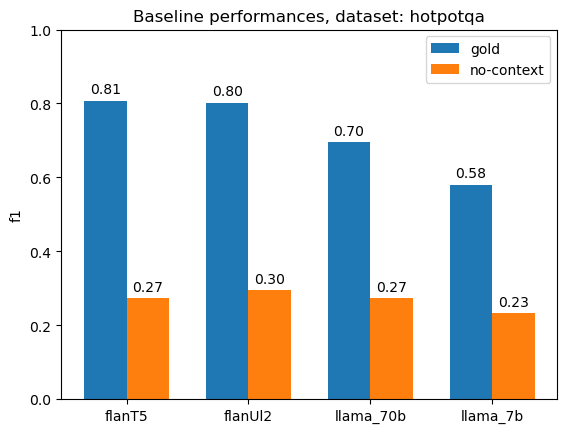

In [215]:
linestyles = ['-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'p']
retriever = 'colbert'
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]
plt.figure(figsize=(7, 5))
reader_models.sort()
dataset = 'hotpotqa'
group1 = []
group2 = []
if 'bioasq' in dataset:
    docid_key = 'pmid'
    docid_name = 'pm'
    section_key = 'section'
    section_name = 'sec'
else:
    docid_key = 'wikipedia_id'
    docid_name = 'wiki'
    section_key = 'start_paragraph_id'
    section_name = 'par'
output_dfs = output_by_dataset[dataset]
for r, reader_model in enumerate(reader_models):
    print(reader_model)
    if 'truncation' in reader_model:
        continue
    for i, baseline in enumerate(['gold', 'no_context']):
        k_df =output_dfs[reader_model][baseline]
        answer_in_context_df = k_df # CAN CHANGE SLICE CONDITION HERE
        reader_perf = np.mean(answer_in_context_df['f1'].values) # CAN CHANGE READER METRIC HERE
        print(baseline, reader_perf)
        if baseline == 'gold':
            group1.append(reader_perf)
        else:
            group2.append(reader_perf)
    print()

import matplotlib.pyplot as plt
import numpy as np

r2 = reader_models.copy()
for r in r2:
    if 'truncation' in r:
        r2.remove(r)

n_models = len(r2)

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(r2))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, group1, width, label='gold')
rects2 = ax.bar(x + width/2, group2, width, label='no-context')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('f1')
ax.set_title(f'Baseline performances, dataset: {dataset}')
ax.set_xticks(x)
ax.set_xticklabels(r2)
ax.legend()
ax.set_ylim(bottom= 0, top = 1.0)

# Function to attach a text label above each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.savefig(f'/data/tir/projects/tir6/general/afreens/dbqa/figs/{dataset}_baselines.pdf', bbox_inches='tight', pad_inches=0)
plt.show()



flanT5
gold 0.8286922805780754
no_context 0.23264011279520622

flanUl2
gold 0.8371519210433557
no_context 0.31970391258371517

llama_70b
gold 0.7448008459640465
no_context 0.4751498061332393

llama_70b_2000_truncation
llama_7b
gold 0.6316531547409235
no_context 0.32886852308776876

llama_7b_2000_truncation


<Figure size 700x500 with 0 Axes>

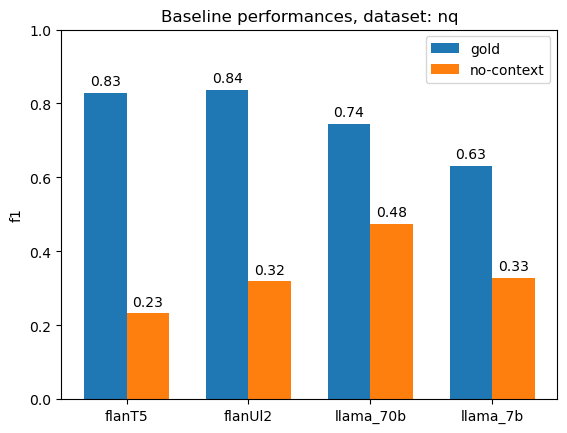

In [212]:
linestyles = ['-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'p']
retriever = 'colbert'
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]
plt.figure(figsize=(7, 5))
reader_models.sort()
dataset = 'nq'
group1 = []
group2 = []
if 'bioasq' in dataset:
    docid_key = 'pmid'
    docid_name = 'pm'
    section_key = 'section'
    section_name = 'sec'
else:
    docid_key = 'wikipedia_id'
    docid_name = 'wiki'
    section_key = 'start_paragraph_id'
    section_name = 'par'
output_dfs = output_by_dataset[dataset]
for r, reader_model in enumerate(reader_models):
    print(reader_model)
    if 'truncation' in reader_model:
        continue
    for i, baseline in enumerate(['gold', 'no_context']):
        k_df =output_dfs[reader_model][baseline]
        answer_in_context_df = k_df # CAN CHANGE SLICE CONDITION HERE
        reader_perf = np.mean(answer_in_context_df['substring_match'].values) # CAN CHANGE READER METRIC HERE
        print(baseline, reader_perf)
        if baseline == 'gold':
            group1.append(reader_perf)
        else:
            group2.append(reader_perf)
    print()

import matplotlib.pyplot as plt
import numpy as np
r2 = reader_models.copy()
for r in r2:
    if 'truncation' in r:
        r2.remove(r)

n_models = len(r2)

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(r2))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, group1, width, label='gold')
rects2 = ax.bar(x + width/2, group2, width, label='no-context')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('f1')
ax.set_title(f'Baseline performances, dataset: {dataset}')
ax.set_xticks(x)
ax.set_xticklabels(r2)
ax.legend()
ax.set_ylim(bottom= 0, top = 1.0)

# Function to attach a text label above each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
# plt.savefig(f'/data/tir/projects/tir6/general/afreens/dbqa/figs/{dataset}_baselines.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

